In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import src.models
import orbax.checkpoint
from src.training import train_utils

Setup to load in checkpoint

In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

T = 1.0
N = 100

num_pts = 10

def get_score(checkpoint_path):
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    batch_stats = restored["batch_stats"]
    trained_score = train_utils.trained_score(model, params, batch_stats)
    sde = restored["sde"]
    return trained_score, sde


In [17]:
import src.data_boundary_pts as data
from src.sdes import sde_ornstein_uhlenbeck, sde_utils, time

pts = data.sample_circle(num_pts, radius=3.0)

checkpoint_path = f"../../checkpoints/ou/time_discretisation_forward_{num_pts}_pts"
trained_score, sde = get_score(checkpoint_path)

key = jax.random.PRNGKey(0)
ts = time.grid(0, T, N)
drift, diffusion = sde_ornstein_uhlenbeck.vector_fields()

conditioned_traj = sde_utils.backward(key, ts, pts, trained_score, drift, diffusion)

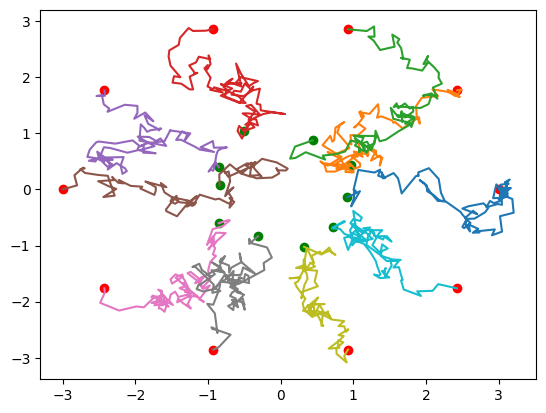

In [18]:
import matplotlib.pyplot as plt

traj = 0
conditioned_traj = conditioned_traj.reshape(-1, num_pts, 2)

init = pts.reshape(-1, 2)

for i in range(num_pts):
    plt.plot(conditioned_traj[:, i, 0], conditioned_traj[:, i, 1])
    plt.scatter(init[i, 0], init[i, 1], c="red")
    plt.scatter(conditioned_traj[-1, i, 0], conditioned_traj[-1, i, 1], c="green")
plt.show()

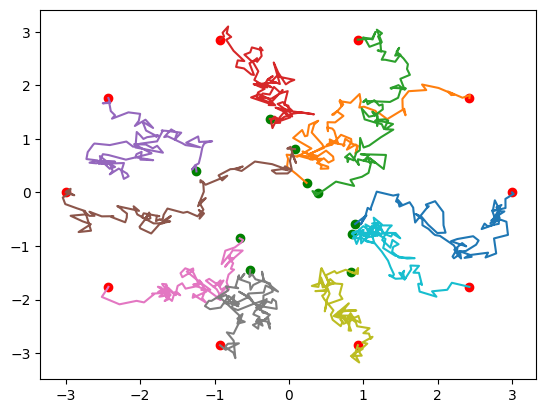

In [19]:
forward_traj = sde_utils.solution(key, ts, pts, drift, diffusion)
forward_traj = forward_traj.reshape(-1, num_pts, 2)

for i in range(num_pts):
    plt.plot(forward_traj[:, i, 0], forward_traj[:, i, 1])
    plt.scatter(init[i, 0], init[i, 1], c="red")
    plt.scatter(forward_traj[-1, i, 0], forward_traj[-1, i, 1], c="green")
plt.show()



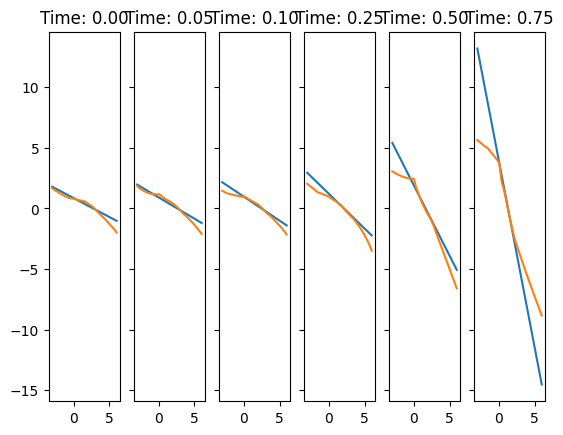

In [11]:
from src.plotting import plot_score
from src.sdes import sde_ornstein_uhlenbeck as ou
import matplotlib.pyplot as plt

checkpoint_path = f"../../checkpoints/ou/time_discretisation_forward_10_pts"

trained_score, sde = get_score(checkpoint_path)
true_score = ou.score